<a href="https://colab.research.google.com/github/andresvc21/Titanic_Kaggle/blob/main/Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TITANIC**


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. We'll upload this data to kaggle to see the results.


# 1. Data Exploration

In [ ]:
# Import relevant packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn import linear_model
import missingno as msno
import seaborn as sns
from scipy.stats import pearsonr

random_state = 2

#Set Plot Style
sns.set_style("dark")

#Want to see N columns during stats and head. If all columns change N to None
pd.set_option('display.max_columns', None)

#Import Data. Official source https://www.kaggle.com/c/titanic/data?select=test.csv
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

print('---------------------------------------------------------')
print('\t\tTrain Head')
print('---------------------------------------------------------')
print(train_data.head())

print('---------------------------------------------------------')
print('\t\tTest Head')
print('---------------------------------------------------------')
print(test_data.head())



---------------------------------------------------------
		Train Head
---------------------------------------------------------
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9

As expected each row of the table represents a specific passenger

In [ ]:
#Columns
list(train_data.columns)
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

From here is easy to conclude that

*   Survived is the phenomenon that we want to predict. It contains two classes: 1 if the passenger survived and 0 otherwise, therefore this use case is a binary classification problem.
*   Age and Fare are numerical variables while the others are categorical.





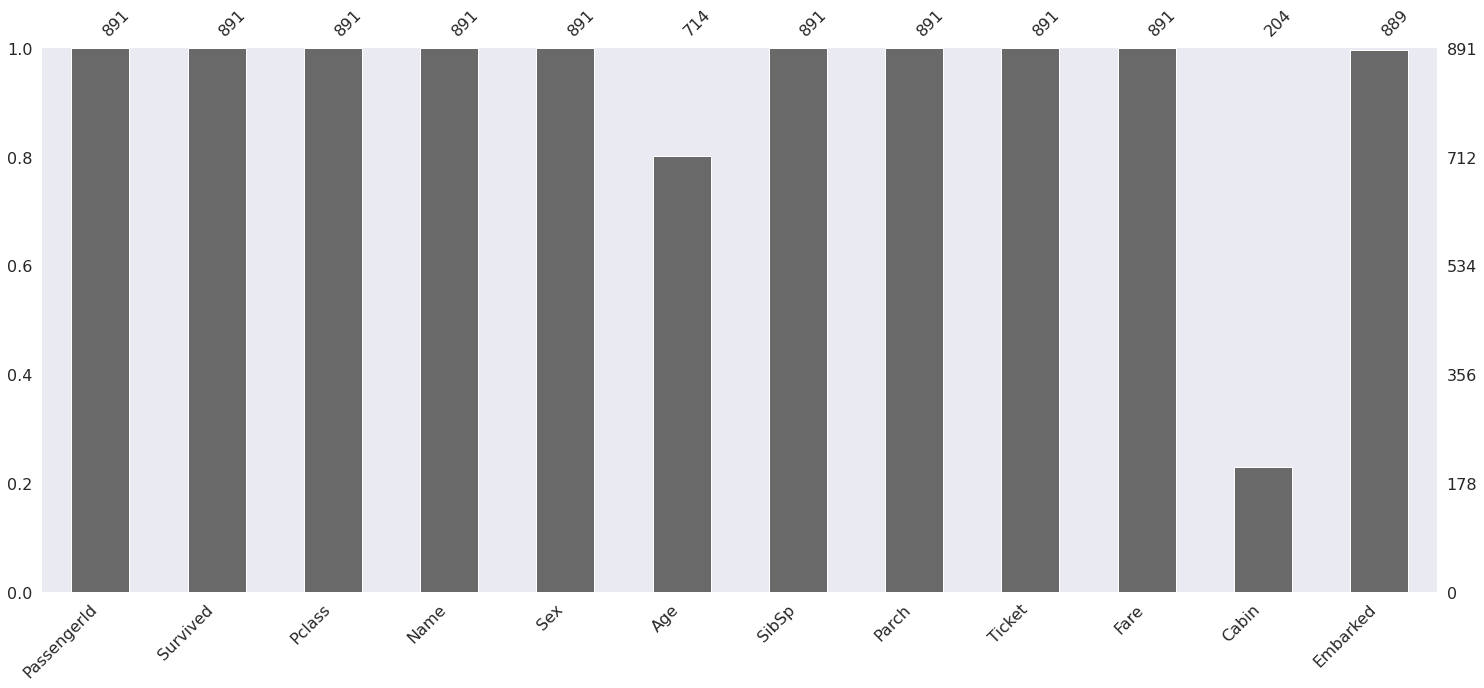

In [ ]:
#NAN First analysis
train_data.isna().any()
msno.bar(train_data)

For the bar chart: On the left side of the plot, the y-axis scale ranges from 0.0 to 1.0, where 1.0 represents 100% data completeness. If the bar is less than this, it indicates that we have missing values within that column.
On the right side of the plot, the scale is measured in index values. With the top right representing the maximum number of rows within the dataframe.

*   Age, Cabin and Embarked contain NaN values



In [ ]:
#The Id should be that one of the passanger, doesn't make sense to consider this varible for the model
train_data = train_data.set_index("PassengerId")

In [ ]:
train_data.describe(include = "all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Porter, Mr. Walter Chamberlain",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
#Lets create a function to plot bar charts according to a feature
def bar(column, stack):
  survived=train_data[train_data["Survived"]==1][column].value_counts()
  dead=train_data[train_data["Survived"]==0][column].value_counts()
  df=pd.DataFrame([survived, dead])
  df.index=["Survived", "Dead"]
  df.plot(kind="bar", stacked=stack, figsize=(8,6))
  plt.title("Survived vs Dead for "+column)
  plt.ylabel("Person Count")
  plt.xticks(rotation=0, horizontalalignment="center")
  plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
  plt.show()

---------------------------------------------------------
		Percentage of Gendre of survivors
---------------------------------------------------------
        Survived
Sex             
female  0.742038
male    0.188908 



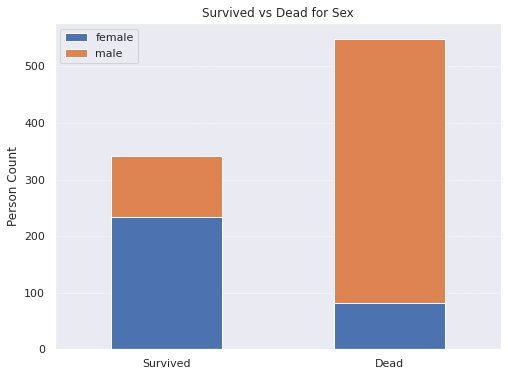

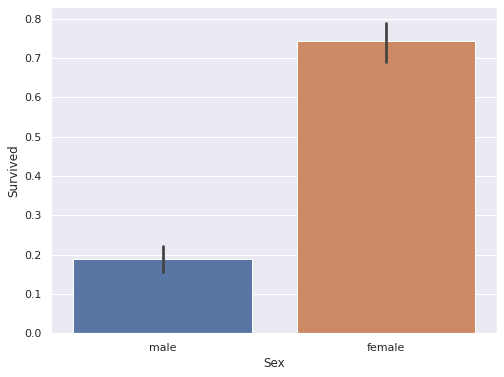

In [ ]:
# See people that survived according to sex
print('---------------------------------------------------------')
print('\t\tPercentage of Gendre of survivors')
print('---------------------------------------------------------')
print(train_data[['Sex', 'Survived']].groupby(['Sex']).mean(), '\n')
bar("Sex", True)
sns.set(rc={'figure.figsize':(8, 6)})
sns.barplot(x="Sex", y="Survived", data=train_data, )

From this figure it's posible to say that Women are more likely survived than Men. And this seems reasonable because of the rule "First women and childrens"

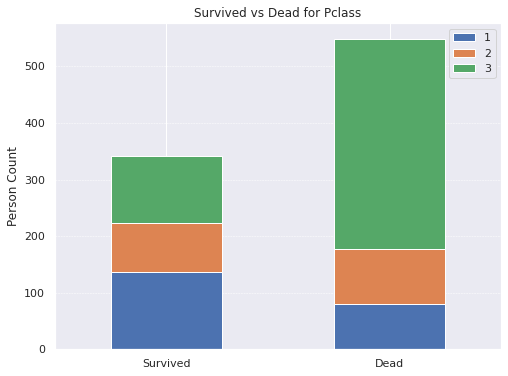

In [ ]:
bar('Pclass', True)

The feature “Pclass” is how much fare a passanger paid for the tree trip. The figure confirms 1st class more likely survived than other classes while 3rd class more likely dead than other classes.

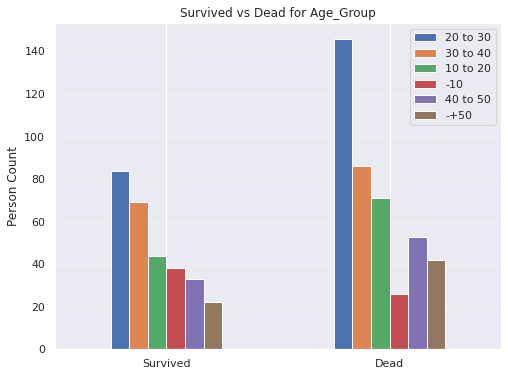

In [ ]:
 #Lets Create some Age Groups 

train_data.loc[train_data['Age']<=10, 'Age_Group']='-10'
train_data.loc[(train_data['Age']>10) & (train_data['Age']<=20) , 'Age_Group']='10 to 20'
train_data.loc[(train_data['Age']>20) & (train_data['Age']<=30) , 'Age_Group']='20 to 30'
train_data.loc[(train_data['Age']>30) & (train_data['Age']<=40) , 'Age_Group']='30 to 40'
train_data.loc[(train_data['Age']>40) & (train_data['Age']<=50) , 'Age_Group']='40 to 50'
train_data.loc[train_data['Age']>50, 'Age_Group']='-+50'
 
 bar("Age_Group", False)

For age we need an unstacked bar maker more sense. And the former is code is to divide the passanger in agre groupps. Clearly, a larger fraction of children under 10 years old survived than died and the opposite for the group of age 20 to 30. To get more information about the age we can do a further exploration in the distribution

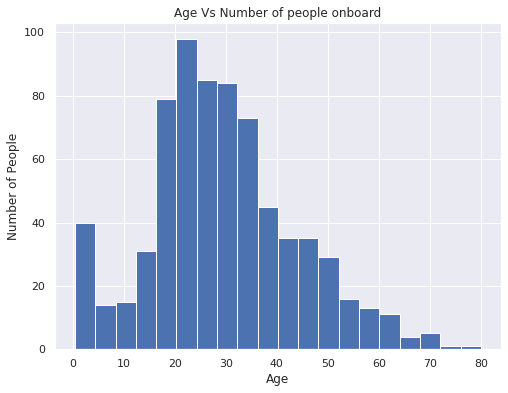

In [ ]:

### distribution
fig = plt.figure(figsize = (8,6))
plt.title('Age Vs Number of people onboard')
plt.xlabel('Age')
plt.ylabel('Number of People')
ax = fig.gca()
train_data['Age'].hist(bins=20, ax=ax)


The passengers were, on average, pretty young: the distribution is skewed towards the left side (the mean is 30 years old and the 75th percentile is 38).

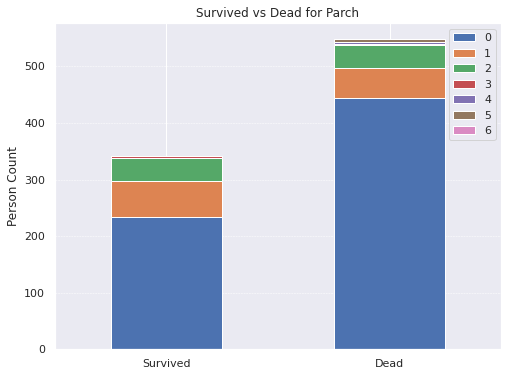

In [ ]:
  bar("Parch", True)

Other interesting category is Parch that refers to number of parents or children aboard the Titanic. A person aboard alone is more likely to dead. To further explore the bars chart is important to use pair plots as the followings:

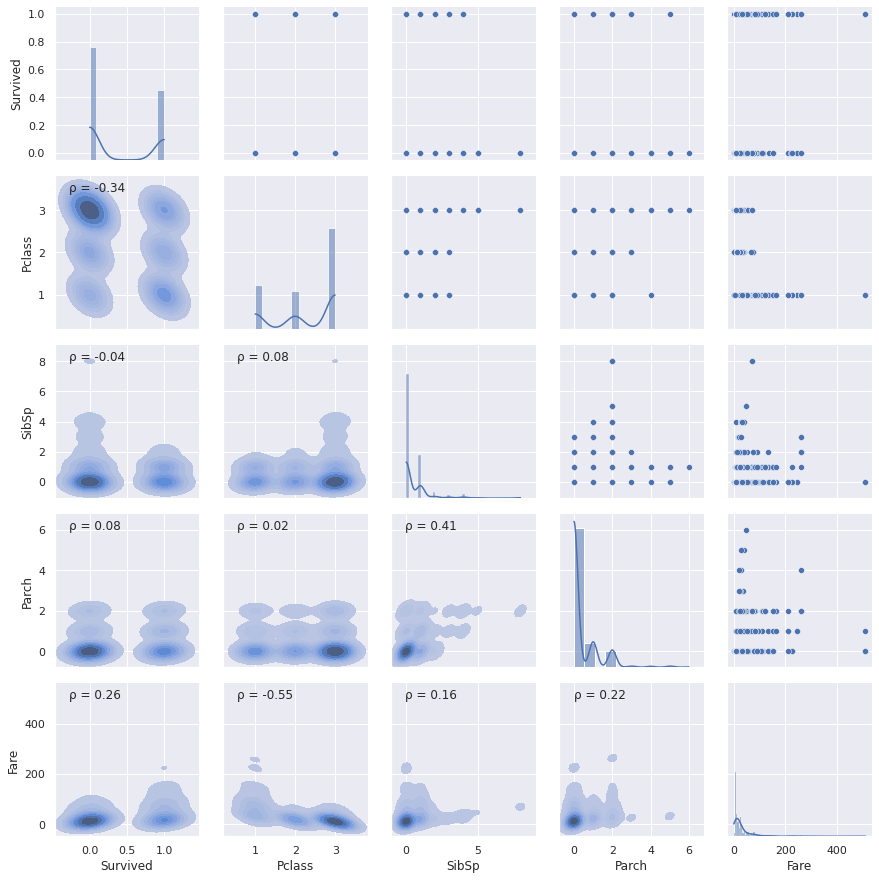

In [ ]:
#Pairplot
def corr_f(x, y, ax=None, **kws):
  """Plot the correlation coefficient in the top left hand corner of a plot."""
  r, _ = pearsonr(x, y)
  ax = ax or plt.gca()
  ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize=12)
  
g = sns.PairGrid(train_data[['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
g.map_lower(corr_f)

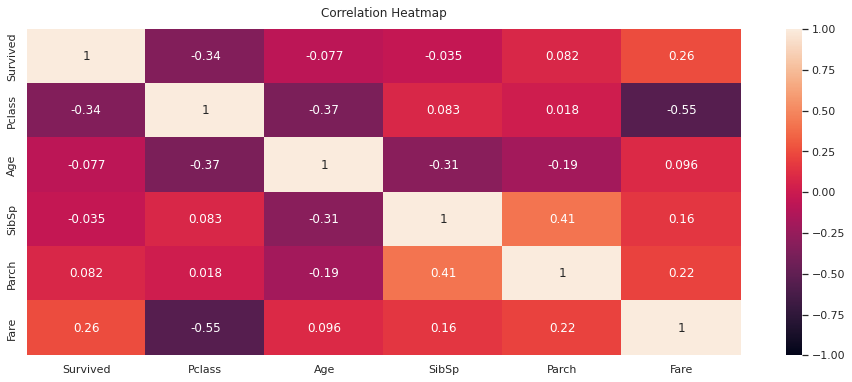

In [ ]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# 2. Cleaning Data

In [ ]:
#checking if the data has null values
print(pd.isnull(train_data).sum())

Survived       0
Pclass         0
Name           0
Sex            0
Age          177
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
Age_Group    177
dtype: int64


In [ ]:
# checking if Age colum has null values
print(train_data['Age'].isnull().values.any()) #has null values

# Filling the missing values of Age with the mean of the respective column
values = {'Age': train_data['Age'].mean()}
train_data.fillna(values, inplace=True)

True


In this case we decided to use de mean value for the age in the whole dataset. Other method is to replace the age in the train and test dataset only with the mean of the train dataset

In [ ]:
#Sanity Check
print(pd.isnull(train_data).sum())

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin        687
Embarked       2
Age_Group    177
dtype: int64


In [ ]:
# Sex is string, need to hot encode
dummies = pd.get_dummies(train_data['Sex'], prefix='Sex', drop_first=True)
train_data = pd.concat([train_data, dummies], axis=1)
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group,Sex_male
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,20 to 30,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,30 to 40,0
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,20 to 30,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,30 to 40,0
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,30 to 40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,20 to 30,1
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,10 to 20,0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,NaN,0


In [ ]:
# Embarked is string, need to hot encode
dummies_embarked = pd.get_dummies(train_data['Embarked'], prefix='Embarked', drop_first=True)
train_data = pd.concat([train_data, dummies_embarked], axis=1)
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,20 to 30,1,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,30 to 40,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,20 to 30,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,30 to 40,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,30 to 40,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,20 to 30,1,0,1
888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,10 to 20,0,0,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,NaN,0,0,1


#3. Model

According to the data exploration and the relation matrix and correlation values from the fomer section we consider that the variables 'Pclass','Age','SibSp','Parch','Fare','Sex_male','Embarked_Q','Embarked_S' will be consider for the model

In [ ]:
from sklearn.model_selection import train_test_split

X = train_data.loc[:, ['Pclass','Age','SibSp','Parch','Fare','Sex_male','Embarked_Q','Embarked_S']]
y = train_data.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)
print('---------------------------------------------------------')
print('\t\tTrain Set Shape')
print('---------------------------------------------------------')
print(X_train.shape)
print('---------------------------------------------------------')
print('\t\tTest Set Shape')
print('---------------------------------------------------------')
print(X_test.shape)



---------------------------------------------------------
		Train Set Shape
---------------------------------------------------------
(712, 8)
---------------------------------------------------------
		Test Set Shape
---------------------------------------------------------
(179, 8)


#3.1. Logistic Regression

In [ ]:
# Train a logistic regression model 
#worrbook 3: confusion amtrix, accuracy, cross validation (worbook 4)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver = 'liblinear', multi_class = 'auto')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Contingency Table: 



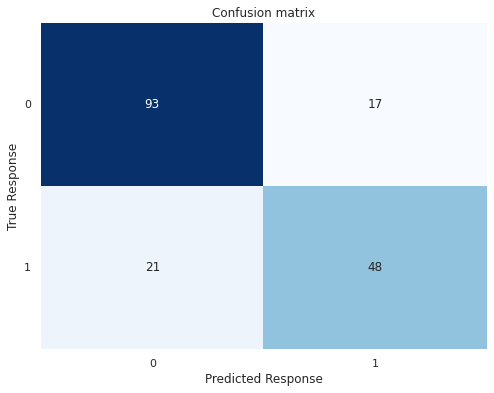


 Accuracy:  0.7877094972067039

 Classification Report: 
                precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
#Metrics
y_predict = logreg.predict(X_test)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
#Cross Validation for logreg
from sklearn.model_selection import cross_val_score

cv_means=[]
cv_std=[]


scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())
cv_means.append(scores.mean())
cv_std.append(scores.std())


Scores: [0.79166667 0.73611111 0.85915493 0.77464789 0.76056338 0.81690141
 0.78873239 0.8028169  0.85915493 0.81690141]
Mean: 0.8006651017214399
Standard Deviation: 0.03748280676387135


Now the logreg model has an average acuracy of 80% and a standar deviation of 3,7%. It dosent make much sense to play with the treshold because we dont have any specific requirments. For the time being lets try other ML models and try to improve the best one


#3.2. Linear Discriminant

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Contingency Table: 



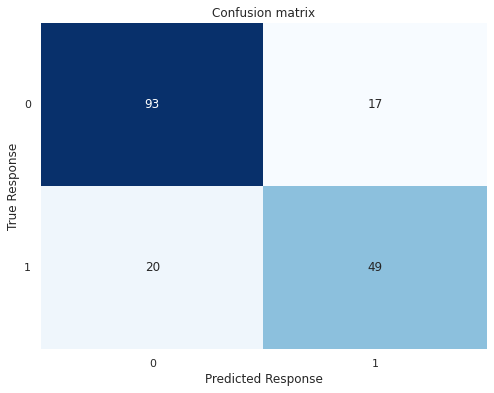


 Accuracy:  0.7932960893854749

 Classification Report: 
                precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.71      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
y_predict = lda.predict(X_test)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
#Cross Validation for lda

scores = cross_val_score(lda, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

cv_means.append(scores.mean())
cv_std.append(scores.std())

Scores: [0.79166667 0.73611111 0.85915493 0.8028169  0.76056338 0.78873239
 0.78873239 0.8028169  0.85915493 0.81690141]
Mean: 0.8006651017214399
Standard Deviation: 0.03640894762896071


#3.3. Quadratic Discriminant Analysis

In [ ]:
 from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

 qda = QuadraticDiscriminantAnalysis()
 qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

Contingency Table: 



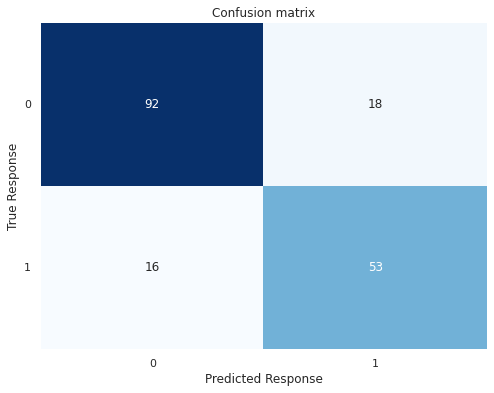


 Accuracy:  0.8100558659217877

 Classification Report: 
                precision    recall  f1-score   support

           0       0.85      0.84      0.84       110
           1       0.75      0.77      0.76        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



In [ ]:
y_predict = qda.predict(X_test)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
#Cross Validation for qda

scores = cross_val_score(qda, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

cv_means.append(scores.mean())
cv_std.append(scores.std())

Scores: [0.80555556 0.75       0.85915493 0.8028169  0.77464789 0.8028169
 0.81690141 0.78873239 0.83098592 0.8028169 ]
Mean: 0.8034428794992176
Standard Deviation: 0.028197364450302388


#3.4. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Contingency Table: 



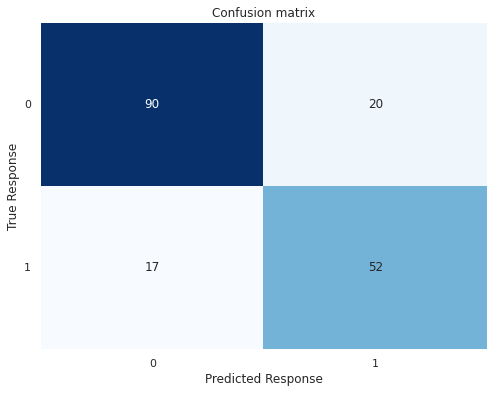


 Accuracy:  0.7932960893854749

 Classification Report: 
                precision    recall  f1-score   support

           0       0.84      0.82      0.83       110
           1       0.72      0.75      0.74        69

    accuracy                           0.79       179
   macro avg       0.78      0.79      0.78       179
weighted avg       0.80      0.79      0.79       179



In [ ]:
y_predict = clf.predict(X_test)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
#Cross Validation for clf

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

cv_means.append(scores.mean())
cv_std.append(scores.std())

Scores: [0.77777778 0.70833333 0.83098592 0.77464789 0.74647887 0.78873239
 0.8028169  0.8028169  0.85915493 0.78873239]
Mean: 0.7880477308294209
Standard Deviation: 0.03962890179484011


#3.4. Decision Tree: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Contingency Table: 



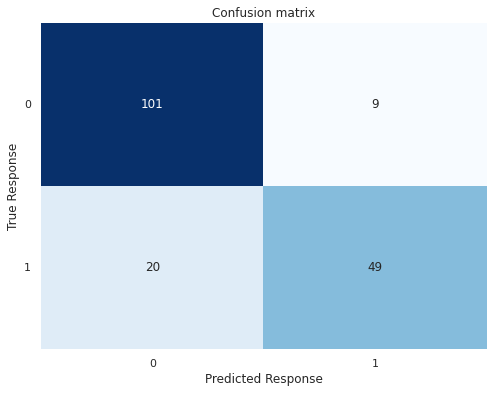


 Accuracy:  0.8379888268156425

 Classification Report: 
                precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.71      0.77        69

    accuracy                           0.84       179
   macro avg       0.84      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



In [ ]:
y_predict = rf.predict(X_test)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
#Cross Validation for rf

scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

cv_means.append(scores.mean())
cv_std.append(scores.std())

Scores: [0.79166667 0.79166667 0.8028169  0.78873239 0.8028169  0.78873239
 0.74647887 0.73239437 0.81690141 0.83098592]
Mean: 0.7893192488262911
Standard Deviation: 0.02819345574991623


These models could have been made with a list and a for loop to get the results. However for visualization reasons we did it this way. Now we will make a graph to compare them

   CrossValMeans  CrossValErrors                      Algorithms
0       0.800665        0.037483             Logistic Regression
1       0.800665        0.036409             Linear Discriminant
2       0.803443        0.028197  Quadratis Discrminant Analayis
3       0.788048        0.039629                     Naive Bayes
4       0.789319        0.028193                   Random Forest


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


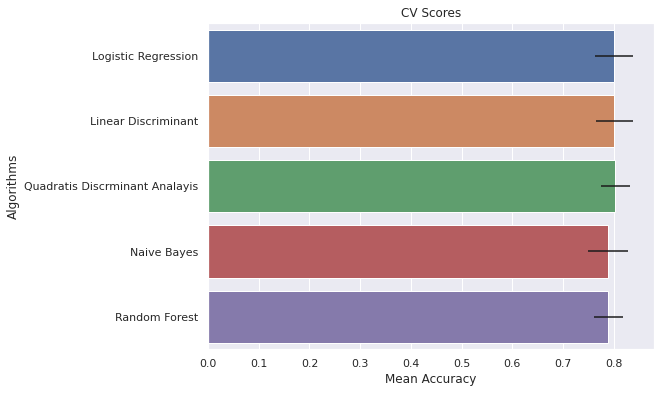

In [ ]:
models=['Logistic Regression', 'Linear Discriminant', 'Quadratis Discrminant Analayis', 'Naive Bayes', 'Random Forest']

cv_frame = pd.DataFrame(
    {
        "CrossValMeans":cv_means,
        "CrossValErrors": cv_std,
        "Algorithms":models
    })
cv_plot = sns.barplot("CrossValMeans","Algorithms", data = cv_frame, orient = "h", **{'xerr':cv_std})

cv_plot.set_xlabel("Mean Accuracy")
cv_plot = cv_plot.set_title("CV Scores")

print(cv_frame)

From this graph Random Forest looks like a good candidate to explore further. Random Forest has a good cross validation mean and not that big variance. 

---------------------------------------------------------
		Table with value of imporatance
---------------------------------------------------------
            importance
feature               
Fare             0.270
Age              0.269
Sex_male         0.256
Pclass           0.078
SibSp            0.051
Parch            0.042
Embarked_S       0.021
Embarked_Q       0.012
---------------------------------------------------------


Text(0, 0.5, 'Importance value')

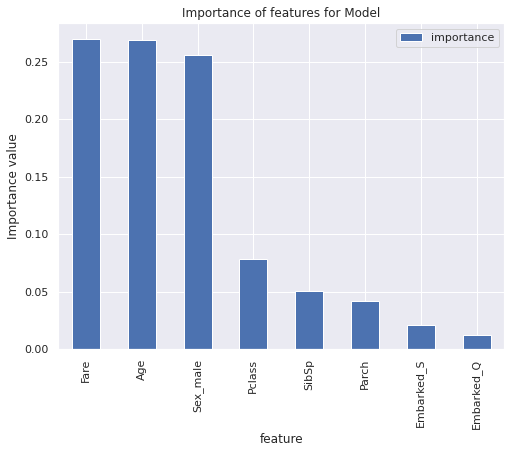

In [ ]:
#Lets start with the importance of each one the variables used to predict

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print('---------------------------------------------------------')
print('\t\tTable with value of imporatance')
print('---------------------------------------------------------')
print(importances)

print('---------------------------------------------------------')
importances.plot.bar()
plt.title('Importance of features for Model')
plt.ylabel('Importance value')



Embarked doesn’t play a significant role in our random forest classifiers prediction process. Because of that I will drop them from the dataset and train the classifier again.

In [ ]:
X_train_new  = X_train.drop("Embarked_S", axis=1)
X_test_new  = X_test.drop("Embarked_S", axis=1)

X_train_new  = X_train.drop("Embarked_Q", axis=1)
X_test_new  = X_test.drop("Embarked_Q", axis=1)

new_random_forest=RandomForestClassifier(n_estimators=100, oob_score = True)
new_random_forest.fit(X_train_new, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

Contingency Table: 



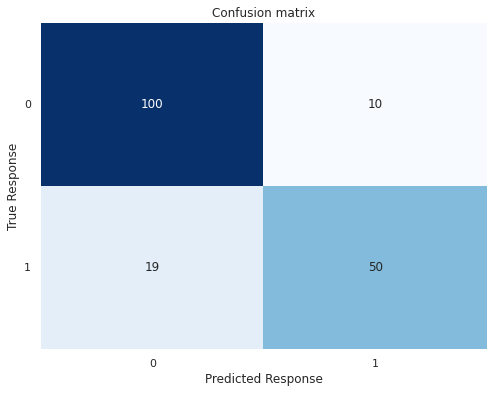


 Accuracy:  0.8379888268156425

 Classification Report: 
                precision    recall  f1-score   support

           0       0.84      0.91      0.87       110
           1       0.83      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179



In [ ]:
y_predict = new_random_forest.predict(X_test_new)
print('Contingency Table: \n')
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Response", ylabel="True Response", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()
print('\n Accuracy: ',accuracy_score(y_predict, y_test))
print('\n Classification Report: \n ',classification_report(y_test, y_predict))

In [ ]:
scores = cross_val_score(new_random_forest, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

cv_means.append(scores.mean())
cv_std.append(scores.std())

Scores: [0.80555556 0.80555556 0.8028169  0.8028169  0.84507042 0.77464789
 0.77464789 0.73239437 0.84507042 0.81690141]
Mean: 0.8005477308294211
Standard Deviation: 0.03206075905264658


As we see the result are slightly better. We started with the data exploration where we got a feeling for the dataset, checked about missing data and learned which features are important. Afterwards we started training different machine learning models, picked one of them (random forest) and try to apply some methos to imporve it. 

# Bibliography



*   Plot With Pandas. URL: https://realpython.com/pandas-plot-python/ 
*   Machine Learning with Python: Classification (complete tutorial). URL: https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec
*   Course Notes. Statistical Machine Learning. McGill. Fall 2021
*   A Titanic Probability. URL: https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html
*   Toward Data Science. Predicting survival of titanic passengers URL: https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8






